In [1]:
%load_ext autoreload
%autoreload 2
from model_dev.dataloader import data_provider
from model_dev.utills import read_default_args, load_model
import json
import argparse
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from model_dev.utills import get_dates_between, get_stock_meta
import pandas as pd

In [2]:
default_args = read_default_args()
config_file = '../../configs/config_akash.json'
data_dir_overrides = ["/Users/akashanand/repo/data/ltsf/iteration1/data_maestro",
                      "/Users/akashanand/repo/data/ltsf/iteration2/data_maestro"]
data_dir_override = data_dir_overrides[0]
config = json.load(open(config_file))
if data_dir_override != "":
    config['data_dir'] = data_dir_override
data_dir = config['data_dir']
raw_dir = "{}/{}".format(data_dir, config['raw_data_dir'])
csv_dir = "{}/{}".format(data_dir, config['raw_data_csv'])
ltsf = "{}/ltsf".format(data_dir)
print("data_dir: {}".format(data_dir))
args = {
    'root_path': ltsf,
    'checkpoints': '{}/checkpoints/'.format(data_dir),
    'data_path': '03_23.csv',
    'seq_len': 120,
    'pred_len': 30,
    'batch_size': 1,
    'learning_rate': 0.025,
    'train_only': False,
    'train_epochs': 20,
    'data_segment': None,
    'model': 'nlinear_attention',
    'enc_in': 397,
    'patience': 5,
    'target': 0,
    'stocks': None
}

for key, value in args.items():
    default_args[key] = value

args = argparse.Namespace(**default_args)
mode = 'train'  #train,val,test
iteration_idx = 0


data_dir: /Users/akashanand/repo/data/ltsf/iteration1/data_maestro


In [3]:
dataloader, _ = data_provider(args, mode, return_date=True)

Original data shape: (14250, 398)
Data shape after inter-day:  8550
train 5836


In [4]:
date_wise_preds = {}
date_wise_actuals = {}
for idx,(x,y,date) in enumerate(dataloader):
    #print("x: {}, y: {}, date: {}".format(x.shape, y.shape, date))
    setting = 'mod_{}_sl{}_pl{}_ds_{}_tg_{}_ch_{}'.format(args.model, args.seq_len, args.pred_len, args.data_path.split('.')[0], args.target, args.enc_in)
    if iteration_idx != 0:
        setting = setting + "_" + str(iteration_idx + 1)
    weights = 'epoch_{}.pth'.format(args.train_epochs)
    weights = os.listdir("{}/{}".format(args.checkpoints, setting))
    sorted_weights = sorted(weights, key=lambda x: float(x.replace('checkpoint_','').replace('.pth','')), reverse=True)
    model = load_model(args)
    model.load_state_dict(torch.load("{}/{}/{}".format(args.checkpoints, setting, sorted_weights[-1])))
    model_in = torch.from_numpy(x).float()
    model_in = model_in.unsqueeze(0)
    model_out = model(model_in)
    model_out = model_out.squeeze(0).detach().cpu().numpy()
    actual_y = y[:, args.target]
    actual_x = x[:,args.target]
    actual_x_dates = get_dates_between(date[0], date[1])
    actual_y_dates = get_dates_between(date[2], date[3])
    for idx, date in enumerate(actual_x_dates):
        date_wise_actuals[date] = actual_x[idx]
    for idx, date in enumerate(actual_y_dates):
        if date not in date_wise_preds:
            date_wise_preds[date] = []
        date_wise_preds[date].append(model_out[idx])
        date_wise_actuals[date] = actual_y[idx]
    

In [5]:
all_dates = []
actuals = []
preds = []
for key, _ in date_wise_actuals.items():
    all_dates.append(key)
# Sort the dates by ascending order
all_dates = sorted(all_dates, key=lambda x: x)
for date in all_dates:
    actuals.append(date_wise_actuals[date])
    if date not in date_wise_preds:
        preds.append([])
    else:
        preds.append(date_wise_preds[date])


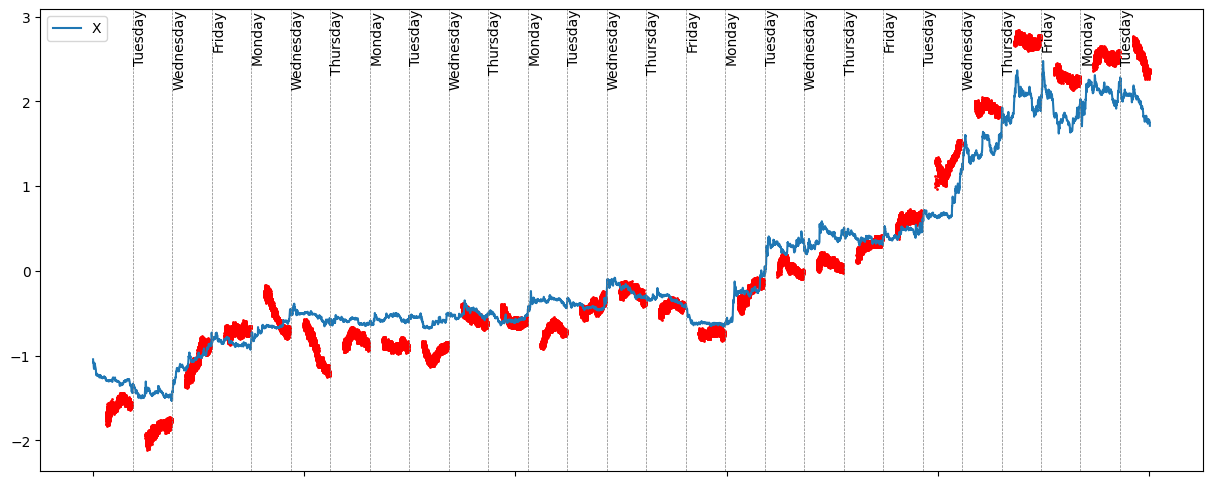

In [11]:
import matplotlib.ticker as ticker

dates = pd.to_datetime(all_dates)
X = actuals
Y = preds

# Create a new figure and an axis to plot on
# Set the figure size to be wider
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the numbers as needed

# Create a range equal to the length of dates. This will be your new x-axis
x_range = range(len(dates))

# Plot X as a line
ax.plot(x_range, X, label='X')

# Plot each set of Y values as dots
x_scatter = []
Y_scatter = []
for i, y in enumerate(Y):
    for y_val in y:
        x_scatter.append(i)
        Y_scatter.append(y_val)

# Use color argument to change the color of the scatter points
ax.scatter(x_scatter, Y_scatter, s=1, color='red')  # Adjust color as needed

# Add vertical lines at the start of each day and add the day of week beside it
prev_date = dates[0].date()
for i, date in enumerate(dates):
    if date.date() != prev_date:
        ax.axvline(i, color='gray', linestyle='--', linewidth=0.5)  # Adjust color, linestyle, and linewidth as needed
        ax.text(i, ax.get_ylim()[1], date.day_name(), rotation=90, verticalalignment='top')  # Add the day of the week
    prev_date = date.date()

# Remove x-axis label
ax.set_xticklabels([])

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [19]:
actual_y

array([-1.28563559, -1.28563559, -1.28860984, -1.28266135, -1.28860984,
       -1.30050683, -1.30050683, -1.30050683, -1.29455833, -1.30050683,
       -1.30050683, -1.29753258, -1.29753258, -1.29753258, -1.29753258,
       -1.29753258, -1.29455833, -1.29455833, -1.29753258, -1.29753258,
       -1.30050683, -1.30050683, -1.30050683, -1.30050683, -1.30050683,
       -1.30645532, -1.30645532, -1.29158409, -1.28860984, -1.29455833])

In [13]:
a = get_stock_meta("{}/instruments.json".format(ltsf), "{}/03_23.csv".format(ltsf))
names = []
for k, v in a.items():
    names.append(v['name'])

In [17]:
names[38]

'HDFC AMC'

In [12]:
!pwd

/Users/akashanand/repo/marketmaestro/maestro/khudra/akash_model_dev
